### TB Classification - `EFFICIENTNET (B7)`

In this notebook we are going to train a model with the help of transfare learning on the `EFFICIENTNET` achitecture that does TB diagonisis based on `Chest X-Ray` images using the dataset that was obtained from kaggle at this url:

> https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset


In the following code cell we are going to install the `helperfns` package that contains some helper functions that we are going to use in this notebook.

In [47]:
!pip install helperfns -q

In the following code cell we are going to import all the packages that we are going to use for the rest of this notebook.

In [48]:
import torch
import random
import os
import time
import torchvision
import copy

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import FileLink
from torch.nn import functional as F
from PIL import Image
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image
from sklearn.metrics import classification_report
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.utils import hms_string

from helperfns import visualization
from torchvision import models
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.5.1+cu121
numpy:  1.26.4
pandas:  2.2.2


Next we are going to define some contants that we are going to use in this notebook.

In [49]:
COLORS = ['#638C6D', '#E7FBB4', '#DF6D2D', '#4C585B', '#474E93', '#D8C4B6', '#118B50']

### Seed

In the following code cell we are going to define the `SEED` for all random operation for reproducivity of results in this notebook.

In [50]:
SEED = 23

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

In the following code cell we are going to create a variable `device` that will hold the value of the device that is available so that we can have access to the `GPU` if available.

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

The dataset that we will be using to train our model was found on Kaggle with the following URL:

> https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset

In the following code cell we are going to define the data path to our dataset.

In [52]:
data_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

### Channels Means and STDs

In the following code cell we are going to compute the means and standard deviations of all color channels in all images in the dataset so that we can use them to normalize the images during transformations.

In [53]:
train_data = datasets.ImageFolder(
    root=data_path,
    transform= transforms.ToTensor()
)

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
  means += torch.mean(img, dim = (1,2))
  stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')


Calculated means: tensor([0.5012, 0.5096, 0.5124])
Calculated stds: tensor([0.2359, 0.2381, 0.2392])


Since we will be using the `EFFICIENTNET` for transfare learning we are going to use the pretrained size that this model expect which is `224`. For the means and standard deviation we are going to use the ones that we computed in the previous code cell for image normalization.

In [54]:
pretrained_size = 224

image_transforms = {
    "train": transforms.Compose([
            transforms.Resize(pretrained_size),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean = means,
                                std = stds)
          ]),
    "valid": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = means,
                            std = stds)
        ]),
    "test": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = means,
                            std = stds)
    ])
}

In the following code cell we are then going to create a dataset `tb_dataset` using the `ImageFolder` class that will map our classes to the respective images and handles a lot of work for us.

In [55]:
tb_dataset = datasets.ImageFolder(data_path, transform = image_transforms['train'])
class_names = tb_dataset.classes
class_names

['Normal', 'Tuberculosis']

We can check the class to index mapping of the dataset as follows..

In [56]:
tb_dataset.class_to_idx

{'Normal': 0, 'Tuberculosis': 1}

### Validation and Test Splits

Our dataset does not have the validation and test set. Since the dataset is small we are going to split the train dataset into 2 sets which will be the validation and test set. And we will use the entire dataset to train the model.

In [57]:
train_data = tb_dataset

VALID_RATIO = .5
n_test_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_test_examples
test_data, valid_data = data.random_split(train_data,
                                           [n_test_examples, n_valid_examples])

> Note that after spliting the train dataset into 2 subsets these 2 subsets will contain transforms of the train data. So we need to overide them. For that we are going to create a copy and overide the train transforms with respective transforms for each set.

In [58]:
valid_data = copy.deepcopy(valid_data)
test_data = copy.deepcopy(test_data)

valid_data.dataset.transform = image_transforms['valid']
test_data.dataset.transform = image_transforms['test']

In the following code cell we are going to use the pie chat to visualize the examples that we have in each subset.

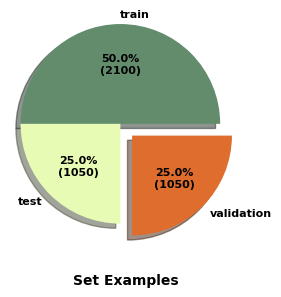

In [59]:
plt.figure(figsize=(3, 3))

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.pie(
    [len(train_data), len(test_data), len(valid_data)], explode= [.0, .0, .1],
    labels=['train', 'test', 'validation'],
    pctdistance=0.6, shadow=True, autopct=lambda x: fmt(x, len(train_data)),
    textprops={'color': 'k', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=COLORS
)
plt.xlabel('Set Examples', weight="bold", fontsize=10, labelpad=20)
plt.axis('equal')
plt.show()

Next we are going to create iterators and we are going to set the batch size to be `64`.

In [75]:
BATCH_SIZE = 16
train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE
)
valid_iterator = data.DataLoader(
    valid_data, batch_size= BATCH_SIZE
)
test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE
)

### Visualizing Images

In this section of the notebook we are going to visualize the images that we have in our dataset with their respective labels.

In [61]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

Next we are going to define the `plot_images` function which is responsible for plotting images.

In [62]:
def plot_images(images, labels, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(class_names[labels[i]], fontsize=10, color='r' if labels[i] == 1 else 'g')
    ax.axis('off')


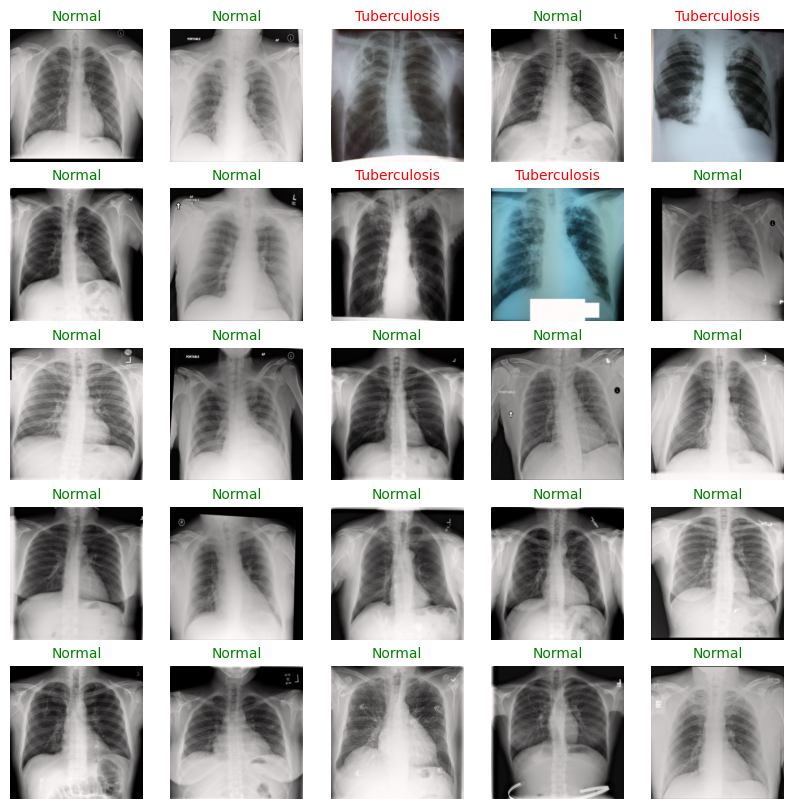

In [63]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [test_data[i] for i in range(N_IMAGES)]])
plot_images(images, labels)

### Pretrained `EFFICIENTNET (B7)`

In the following code cell we are going to load the `EFFICIENTNET` model with it's weight.

In [64]:
efficientnet = models.efficientnet_b7(weights = True).to(device)

Next we are going to define the output dimension that matches the labels of our task.


> Note that we are not going to freeze the model in this case because we want to retrain the model and be able to update the weights to get the better results.

In [65]:
OUTPUT_DIM = 1

def freeze_model(model):
  for param in model.parameters():
    param.requires_grad = False

Next we are going to update the output layer of our `EFFICIENTNET` to match the output size of `1` since we are doing a binary classification on chest X-ray images. 

In [66]:
efficientnet.classifier[-1] = nn.Linear(efficientnet.classifier[-1].in_features, OUTPUT_DIM).to(device)

Next we are going to create a function that will count the model parameters.

In [67]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return f'{total_params:,}', f'{trainable_params:,}', f'{total_params - trainable_params:,}'

Then we will visualize the model parameters using a table.

In [68]:
tabulate_data(
    ["NAME", "TOTAL PARAMETERS", "TRAINABLE PARAMETERS", "NON-TRAINABLE PARAMETERS"],
    [
      ['EFFICIENTNET', *count_params(efficientnet)],
    ],
    "MODELS' PARAMETERS"
)


MODELS' PARAMETERS
+--------------+------------------+----------------------+--------------------------+
| NAME         | TOTAL PARAMETERS | TRAINABLE PARAMETERS | NON-TRAINABLE PARAMETERS |
+--------------+------------------+----------------------+--------------------------+
| EFFICIENTNET |       63,789,521 |           63,789,521 |                        0 |
+--------------+------------------+----------------------+--------------------------+


### Criterion and Optmizer

Next we are going to define the optmizer to be `Adam` with default parameters and the loss function to be `BCELossWithLogitsLoss` since it is a binary classification task.

In [69]:
optimizers = {
    'efficientnet': torch.optim.Adam(efficientnet.parameters())
}
criterion = nn.BCEWithLogitsLoss().to(device)

Next we are going to define the `binary_accuracy` function that will calculate the accuracy between predicted labels and real labels.

In [70]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Train and Evaluate Functions

In the following code cell we are going to define the `train` and `evaluate` fuctions.

In [71]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for x, y in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).float() # they should be float
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)

    # Calculate the loss and accuracy
    loss = criterion(y_pred, y.unsqueeze(1))
    acc = binary_accuracy(y_pred.squeeze(), y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for x, y in iterator:
      x = x.to(device)
      y = y.to(device).float()  # they should be float
      y_pred = model(x)
      loss = criterion(y_pred, y.unsqueeze(1))
      acc = binary_accuracy(y_pred.squeeze(), y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

Next we are going to create a `History` wrapper class so that we can keep in track of the model's metrics during training.

In [72]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

Next we are going to define the `train_model` function which is responsible for training the model and return model training history.

In [76]:
EPOCHS = 20
def train_model(model, model_name, train_iterator, optimizer, criterion, device, valid_iterator):
  best_valid_loss = float('inf')
  column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
  last_saved_epoch = 1

  history = History()
  training_start = time.time()
  for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      save_status = "(saving)"
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), model_name)

    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


    data_rows = [
        ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
    ]

    title = f"{model_name.replace('.pt', '')}: EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    tabulate_data(column_names, data_rows, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

Next we are going to run the train loop.

In [77]:
efficientnet_history, efficientnet_training_end, efficientnet_last_saved_epoch = train_model(
    efficientnet, 'tb-efficientnet.pt', train_iterator, optimizers['efficientnet'], criterion, device, valid_iterator
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 14.12 MiB is free. Process 3012 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Model Training Time.

In the following code cell, using a table we are going to visualize the model's total training time and last saved epoch.

In [ ]:
rows = [
    ['efficientnet', f'{EPOCHS}', f'{hms_string(efficientnet_training_end)}', f'{efficientnet_last_saved_epoch}']
]
tabulate_data(['MODEL','TOTAL EPOCHS', 'TOTAL TRAINING TIME', 'LAST SAVED EPOCH'], rows, "TOTAL TRAINING TIME")

In the following code cell we are then going to visualize the model's training time per epoch/

In [ ]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, efficientnet_history.epoch_train_time, label="efficientnet", color=COLORS[6])
plt.title("MODEL'S EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Validation and Training Accuracies

In the following code cell we are going to visualize the model's training and validation accuracies per epoch using line graphs

In [ ]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [i * 100 for i in efficientnet_history.train_acc], label="training", color=COLORS[2])
plt.plot(epochs, [i * 100 for i in efficientnet_history.val_acc], label="validation", color=COLORS[6])
plt.title("VALIDATION & TRAINING EPOCH ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Validation and Training Losses

In the following code cell we are going to visualize the model's training and validation losses per epoch using line graphs

In [ ]:
plt.figure(figsize=(5, 3), dpi=80)

plt.plot(epochs, efficientnet_history.train_losses, label="training", color=COLORS[2])
plt.plot(epochs, efficientnet_history.val_losses, label="validation", color=COLORS[6])

plt.title("VALIDATION & TRAINING EPOCH LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Best Model Evaluation

In the following code cell we are going to create a function that will evaluate the best saved model during training interms of loss and accuracy based on the testing dataset.

In [ ]:
def evaluate_best_model(model, model_name, test_iterator, criterion, device):
  model.load_state_dict(torch.load(model_name, weights_only=True))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  return f'{test_loss:.2f}', f'{test_acc * 100:.2f}'


tabulate_data(
    ["NAME", "LOSS", "ACCURACY (%)"],
    [
        ['EFFICIENTNET', *evaluate_best_model(efficientnet, 'tb-efficientnet.pt', test_iterator, criterion, device)],
    ],
    "BEST MODEL'S LOSS AND ACCURACY"
)

### Model Evaluation metrics
In this section we are going to evaluate the best model and visualize the matrics. We are going to use the following evaluation methods on this classification task.

1. confusion matrix
2. classification report.


First we need to get all the predictions from the train dataset.

In [ ]:
#  I need to play around with this function
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)
      y_prob = F.sigmoid(y_pred).squeeze().detach()
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob)
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs
    
test_images, test_labels, probs = get_predictions(efficientnet, test_iterator, device)

Next we are going to convert our predictions from probabilities to real labels.

In [ ]:
preds = torch.round(probs).cpu().numpy().astype(np.int32)
test_labels = test_labels.numpy()

### Plotting Predictions

In this section we are going to plot the predictions.

In [ ]:
test_images_labels = list(zip(test_images, preds, test_labels))
random.shuffle(test_images_labels)
y_true = []
y_pred = []
images = []

for img, pred, label in test_images_labels[:24]:
  y_true.append(label)
  y_pred.append(pred)
  images.append(img)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

Next we are going to define the function that will plot the predictions for us.

In [ ]:
def plot_predictions_images(images_and_classes,
                            labels_true, labels_pred,
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        image = normalize_image(image)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

plot_predictions_images(images[:24], y_true[:24], y_pred[:24], cols=8)


### Confusion Matrix

In the following code cell we are going to visualize the confusion matrix of our model based on the test dataset.

In [ ]:
plot_complicated_confusion_matrix(test_labels, preds, class_names,
                                  fontsize=10, figsize=(5, 5), title="EFFICIENTNET: Confusion Matrix")

### Classification Report

In the following code cell we are going to print the classification report of our best model based on the test datast.

In [ ]:
cr = classification_report(test_labels, preds, output_dict=False)
print(cr)

In the following code cell we are going to the plot the confusion matrix.

In [ ]:
fig, ax = visualization.plot_classification_report(test_labels, preds,
                    title='EFFICIENTNET: Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names = class_names)

### Mis Predicted X-Rays

In this section we are going to plot the mispredicted images of X-rays if there are available.

In [ ]:
corrects = torch.eq(torch.from_numpy(test_labels), torch.from_numpy(preds))

In [ ]:
probabilities = torch.tensor(
    [float(probs[i] if probs[i] >= .5 else 1 - probs[i]) for i in preds]
)

In [ ]:
def get_incorrect_examples(images, labels, probabilities, corrects):
  incorrect_examples = []
  for image, label, prob, correct in zip(images, labels, probabilities, corrects):
    if not correct:
      incorrect_examples.append((image, label, prob))
  return incorrect_examples

incorrect_examples = get_incorrect_examples(test_images, test_labels, probabilities, corrects)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (6, 4))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1, 2, 0)
    true_class = classes[true_label]
    incorrect_class = classes[0 if true_label == 1 else 1]
    if normalize:
      image = normalize_image(image)
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'real: {true_class}\n' \
                  f'predicted: {incorrect_class}', fontsize=8)
    ax.axis('off')
  fig.subplots_adjust(hspace=0.4)

In the following code cell we are going to plot the most mispredicted `X-Ray` images by the model.

In [ ]:

N_IMAGES = 8
try:
    plot_most_incorrect(incorrect_examples, class_names, N_IMAGES)
except:
    print("No incorrectly Predicted Images")

### Model Inference

In this section we are going to load one of the images from the file system and create a function that will make predictions using our model based on that image.

In [ ]:
normal_xray = os.path.join(
    data_path, 'Normal', os.listdir(os.path.join(data_path, 'Normal'))[0]
)
tb_xray = os.path.join(
    data_path, 'Tuberculosis', 
    os.listdir(os.path.join(data_path, 'Tuberculosis'))[0]
)

Next we are going to define a function that will process the image by transforming it using the `test` transforms.

In [ ]:
def preprocess_img(img:str):
  """
  takes in an image path and pre process it
  """
  img = image_transforms['test'](Image.open(img).convert('RGB'))
  return img

The following function will then make predictions using the model and give a prediction response.

In [ ]:
def predict_tb(model, image, device):
    image = preprocess_img(image)
    image = torch.unsqueeze(image, 0).to(device)
    model.eval()
    with torch.no_grad():
        pred = F.sigmoid(model(image).squeeze().cpu()).item()
        predicted_label = 1 if pred >= 0.5 else 0
        confidence = pred if pred >= 0.5 else 1 - pred
        res ={
            'label': predicted_label,
            'class_label': class_names[predicted_label],
            'probability': float(np.round(confidence, 2))
        }
        return res

Predicting the `Normal X-Ray` image.

In [ ]:
predict_tb(efficientnet, normal_xray, device)

Predcicting the `Tuberculosis X-Ray`  image.

In [ ]:
predict_tb(efficientnet, tb_xray, device)

### Downloading Model

In the following code cell we are then going to download the best saved model.

In [ ]:
FileLink(r'tb-efficientnet.pt')